# TOPP-HATT

In some cases, we want to optimise an encoding without changing the underlying tree structure. For instance, we may want to use exactly the tree output from the [Bonsai Algorithm](https://ferrmion.readthedocs.io/en/latest/notebooks/bonsai.html).

`ferrmion` lets you do this with the `topphatt` algorithm.

Currently there are two slightly different implementations, 
- `ferrmion.optimize.topphatt`
- `ferrmion.core`

For more details, see our [preprint](https://arxiv.org/abs/2512.13580).

In [1]:
from ferrmion import core
from ferrmion.utils import fermionic_to_sparse_majorana
from ferrmion.core import anneal_enumerations, encode, standard_symplectic_matrix
from ferrmion.optimize import topphatt
from ferrmion.encode import TernaryTree

import numpy.random as rng
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from pathlib import Path
from copy import deepcopy
import json

We'll start as always by loading in some one and two electron integrals.

In [2]:
# from openfermion.chem.pubchem import geometry_from_pubchem
# from openfermion.chem.molecular_data import MolecularData
# from openfermion.chem.molecular_data import spinorb_from_spatial
# import openfermionpyscf

# geometry=geometry_from_pubchem("H2O")
# mol = MolecularData(geometry=geometry, basis="sto-3g", multiplicity=1)
# mol = openfermionpyscf.run_pyscf(molecule=mol, run_scf=True)
# ones, twos = spinorb_from_spatial(mol.one_body_integrals, mol.two_body_integrals)


folder = Path.cwd().joinpath(Path("../../../python/tests/data/"))

with open(folder.joinpath("h2o_sto-3g.json"), 'r') as file:
    data = json.load(file)

ones = np.array(data["ones"])
twos = np.array(data["twos"])
enuc = data["constant_energy"]

In [3]:
def pauli_weights(pauli_hamiltonian: dict[str, float]) -> list[float]:
    unscaled_terms = []
    scaled_terms = []
    for k, v in pauli_hamiltonian.items():
        assert v != 0
        pw = (len(k) - k.count("I")) 
        unscaled_terms.append(pw)
        scaled_terms.append(pw* np.abs(v))

    return (np.sum(unscaled_terms), np.sum(scaled_terms), len(pauli_hamiltonian))

In [4]:
def get_naive_result(name, tree, ones, twos, enuc):
    print("Getting Naive result...")
    sdmeans_naive = {}
    ipow, sym = standard_symplectic_matrix(name, tree.n_modes)
    result = pauli_weights(encode(ipow, sym, ["+-","++--"], [ones, twos], enuc))
    print("Naive result:", result)

    sdmeans_naive = {}
    sdmeans_naive["unscaled"] = result[0]
    sdmeans_naive["scaled"] = result[1]
    sdmeans_naive["length"] = result[2]
    return sdmeans_naive

def get_permuation_results(name, tree, ones, twos, enuc, limit):
    print(f"\nGetting {limit} random results...")
    sdmeans = {}
    sdmeans = {"unscaled":[], "scaled":[], "length":[]}
    ipow, sym = standard_symplectic_matrix(name, tree.n_modes)
    rng = np.random.default_rng(1017)
    
    for i in range(limit):
        if i % 10 == 0:
            print(i)
        perm = rng.permutation(ones.shape[0])
        perm_index = np.ravel(np.column_stack((2*perm, 2*perm +1)))
        result = pauli_weights(encode(ipow[perm_index], sym[perm_index], ["+-", "++--"], [ones, twos], enuc))
        sdmeans["unscaled"].append(result[0]) 
        sdmeans["scaled"].append(result[1])
        sdmeans["length"].append(result[2]) 
        
    print("Permutation Results")

    return sdmeans

def get_annealed_result(name, tree, ones, twos, enuc, coef_weight):
    print("\nGetting Annealed result...")
    sdmeans_annealed = {}
    sdmeans_annealed = {"unscaled":[], "scaled":[], "length":[]}
    ipow, sym = standard_symplectic_matrix(name, tree.n_modes)
    print("Beginning Annealing")
    anneal_ipow, anneal_sym = anneal_enumerations(ipowers=ipow, symplectics=sym, signatures=["+-","++--"], coeffs=[ones, twos], temperature=ones.shape[0], initial_guess=np.array([*range(ones.shape[0])],dtype=np.uint), coefficient_weighted=coef_weight)
    print("Finished annealing.")
    anneal_ham = encode(anneal_ipow, anneal_sym, ["+-","++--"], [ones, twos], enuc)
    result = pauli_weights(anneal_ham)
    print("Annealed result:", result)
    sdmeans_annealed["unscaled"].append(result[0])
    sdmeans_annealed["scaled"].append(result[1])
    sdmeans_annealed["length"].append(result[2])
    return sdmeans_annealed

def get_python_topphatt_result(name, tree, ones, twos, enuc):
    sparse_ham = fermionic_to_sparse_majorana(((deepcopy(ones),"+-"), (deepcopy(twos), "++--")))

    print("\nRunning python TOPP-HATT...")
    hatt_tree: TernaryTree = topphatt(deepcopy(sparse_ham), tree=tree)
    print(f"python TOPPHATT weight {hatt_tree.pauli_weight}")
    print("Getting python TOPP-HATT result...")
    ipow, sym = hatt_tree._build_symplectic_matrix()
    result = pauli_weights(encode(ipow, sym, ["+-","++--"], [ones, twos], enuc))
    print("Python TOPP-HATT result:", result)
    sdmeans_topphatt_py = {}
    sdmeans_topphatt_py["unscaled"] = result[0]
    sdmeans_topphatt_py["scaled"] = result[1]
    sdmeans_topphatt_py["length"] = result[2]
    return sdmeans_topphatt_py

def get_rust_topphatt_result(name, tree, ones, twos, enuc):
    print("\nRunning rust TOPP-HATT...")
    n_modes = ones.shape[0]
    if name in ["Jordan-Wigner", "Parity", "Bravyi-Kitaev", "JKMN", "JW", "BK", "PE"]:
        ipow,sym = core.topphatt_standard(name, n_modes, n_modes, ["+-","++--"], [ones, twos])
    else:
        ipow,sym = core.topphatt(n_modes, tree.flatpack(), ["+-","++--"], [ones, twos])
        
    print("\nGetting rust TOPP-HATT result...")
    result = pauli_weights(encode(ipow, sym, ["+-","++--"],[ones,twos],enuc))
    print("TOPP-HATT result:", result)
    
    sdmeans_topphatt = {}
    sdmeans_topphatt["unscaled"] = result[0]
    sdmeans_topphatt["scaled"] = result[1]
    sdmeans_topphatt["length"] = result[2]
    return sdmeans_topphatt

def get_topp_hatt_results(name:str, ones, twos, enuc, limit=50):
    tree: TernaryTree = TernaryTree(ones.shape[0])

    match name:
        case "BK" | "Bravyi-Kitaev":
            tree = tree.BravyiKitaev()
        case "JW" | "Jordan-Wigner":
            tree = tree.JordanWigner()
        case "PE" | "Parity":
            tree = tree.ParityEncoding()
        case "JKMN":
            tree = tree.JKMN()

    initial_ones = deepcopy(ones)
    initial_twos = deepcopy(twos)

    sdmeans = get_permuation_results(name, tree, ones, twos, enuc, limit)

    sdmeans_naive = get_naive_result(name, tree, ones, twos, enuc)

    sdmeans_annealed_pw = get_annealed_result(name, tree, ones, twos, enuc, False)
    sdmeans_annealed_cpw = get_annealed_result(name, tree, ones, twos, enuc, True)

    # sdmeans_topphatt_py = get_python_topphatt_result(name, tree, ones, twos, enuc)

    sdmeans_topphatt = get_rust_topphatt_result(name, tree, ones, twos, enuc) 

    color_set = {"jw":"tab:blue", "pe":"tab:orange", "bk":"tab:green", "jkmn":"tab:red", "bonsai":"tab:purple", "huffman":"tab:brown", "hatt":"tab:pink"}
    fig, ax = plt.subplots(layout="constrained")

    ax.scatter(sdmeans["unscaled"], sdmeans["scaled"], label="Randomised Permutations", marker=".", color="tab:grey", alpha=0.7)
    ax.plot(sdmeans_naive["unscaled"], sdmeans_naive["scaled"], marker="D", color="tab:red", mec="k", markersize=8)
    ax.plot(sdmeans_annealed_pw["unscaled"], sdmeans_annealed_pw["scaled"], marker="P", color="tab:orange", mec="k", markersize=8)
    ax.plot(sdmeans_annealed_cpw["unscaled"], sdmeans_annealed_cpw["scaled"], marker="X", color="tab:orange", mec="k", markersize=8)
    ax.plot(sdmeans_topphatt["unscaled"], sdmeans_topphatt["scaled"], marker="P", color="tab:green", mec="k", markersize=8)
    # ax.plot(sdmeans_topphatt_py["unscaled"], sdmeans_topphatt_py["scaled"], marker="X", color="tab:blue", mec="k", markersize=8)

    # where some data has already been plotted to ax
    handles, labels = plt.gca().get_legend_handles_labels()
    # manually define a new patch 
    naive_legend = mlines.Line2D([], [], label='Naive Enumeration', marker="D", linestyle="", color="tab:red", mec="k", markersize=8)
    annealed_pw_legend = mlines.Line2D([], [], label='$W_{P}$ Annealed Best', marker="P", linestyle="",color="tab:orange", mec="k", markersize=8)
    annealed_cpw_legend = mlines.Line2D([], [], label='$W_{CP}$ Annealed Best', marker="X", linestyle="",color="tab:orange", mec="k", markersize=8)
    topphatt_legend = mlines.Line2D([], [], label='TOPP-HATT-Rust', marker="P", linestyle="",color="tab:green", mec="k", markersize=8)

    assert np.all(initial_ones == ones)
    assert np.all(initial_twos == twos)

    # handles is a list, so append manual patch
    handles.extend([
                    naive_legend,
                    annealed_pw_legend, 
                    annealed_cpw_legend, 
                    topphatt_legend,
                    ])

    ax.set_xlabel("unscaled pauli-weight")
    ax.set_ylabel("coefficient scaled pauli-weight")
    ax.set_title(f"{name} Encodings of $H_2 O$:$STO-3G$")
    fig.legend(handles=handles, loc="outside lower center", ncols=len(handles)//2)
    fig.show()




Getting 50 random results...
0
10
20
30
40
Permutation Results
Getting Naive result...
Naive result: (np.int64(14749), np.float64(191.3421429310778), 2035)

Getting Annealed result...
Beginning Annealing
Finished annealing.
Annealed result: (np.int64(11214), np.float64(149.2904007246654), 2035)

Getting Annealed result...
Beginning Annealing
Finished annealing.
Annealed result: (np.int64(14096), np.float64(145.11560007975464), 2035)

Running rust TOPP-HATT...

Getting rust TOPP-HATT result...
TOPP-HATT result: (np.int64(10910), np.float64(146.37080762583477), 2035)


/var/folders/b6/r25qxhld1ls1sll052q1dw5h0000gn/T/ipykernel_38576/3945164212.py:145: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


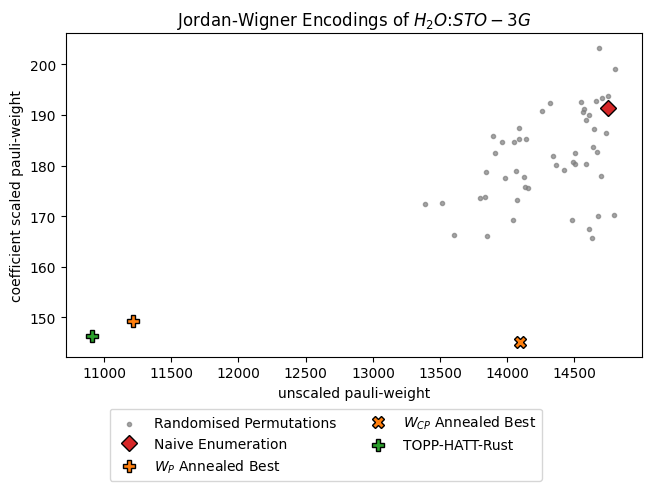

In [5]:
get_topp_hatt_results("Jordan-Wigner", ones, twos, enuc)



Getting 50 random results...
0
10
20
30
40
Permutation Results
Getting Naive result...
Naive result: (np.int64(15040), np.float64(256.80196979954803), 2035)

Getting Annealed result...
Beginning Annealing
Finished annealing.
Annealed result: (np.int64(11329), np.float64(209.76641246130148), 2035)

Getting Annealed result...
Beginning Annealing
Finished annealing.
Annealed result: (np.int64(14590), np.float64(190.46865214582067), 2035)

Running rust TOPP-HATT...

Getting rust TOPP-HATT result...
TOPP-HATT result: (np.int64(11392), np.float64(214.42172692071577), 2035)


/var/folders/b6/r25qxhld1ls1sll052q1dw5h0000gn/T/ipykernel_38576/3945164212.py:145: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


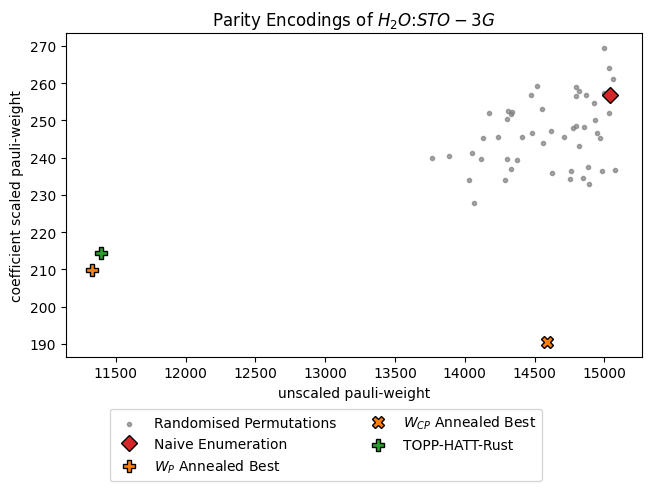

In [6]:
get_topp_hatt_results("Parity", ones, twos, enuc)



Getting 50 random results...
0
10
20
30
40
Permutation Results
Getting Naive result...
Naive result: (np.int64(12662), np.float64(292.03224577227735), 2035)

Getting Annealed result...
Beginning Annealing
Finished annealing.
Annealed result: (np.int64(11221), np.float64(231.2391093963269), 2035)

Getting Annealed result...
Beginning Annealing
Finished annealing.
Annealed result: (np.int64(12471), np.float64(185.41165072194312), 2035)

Running rust TOPP-HATT...

Getting rust TOPP-HATT result...
TOPP-HATT result: (np.int64(11258), np.float64(186.97511067437935), 2035)


/var/folders/b6/r25qxhld1ls1sll052q1dw5h0000gn/T/ipykernel_38576/3945164212.py:145: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


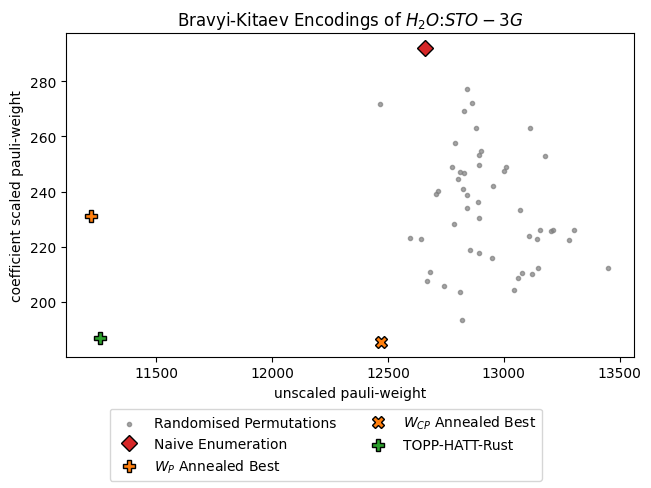

In [7]:
get_topp_hatt_results("Bravyi-Kitaev", ones, twos, enuc)


Getting 50 random results...
0
10
20
30
40
Permutation Results
Getting Naive result...
Naive result: (np.int64(12707), np.float64(277.788890289255), 2035)

Getting Annealed result...
Beginning Annealing
Finished annealing.
Annealed result: (np.int64(11722), np.float64(181.05663040518783), 2035)

Getting Annealed result...
Beginning Annealing
Finished annealing.
Annealed result: (np.int64(12165), np.float64(180.66462060441853), 2035)

Running rust TOPP-HATT...

Getting rust TOPP-HATT result...
TOPP-HATT result: (np.int64(12079), np.float64(213.97716063814212), 2035)


/var/folders/b6/r25qxhld1ls1sll052q1dw5h0000gn/T/ipykernel_38576/3945164212.py:145: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


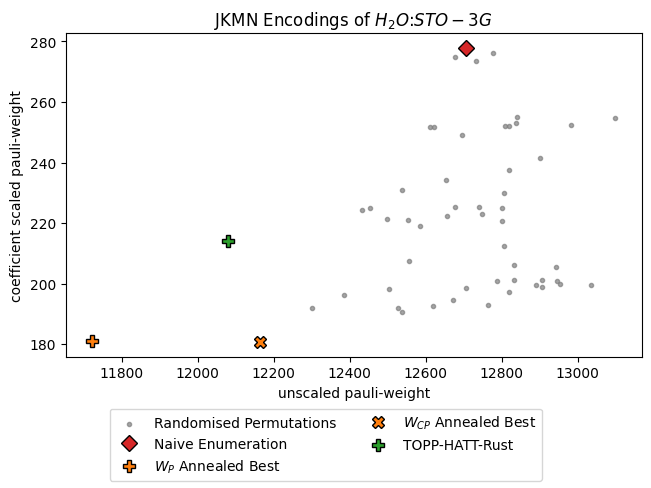

In [8]:
get_topp_hatt_results("JKMN", ones, twos, enuc)